# Prediction using SPSS Flow deployed in WML

**(C) 2019 IBM - Philippe Gregoire - Ecosystem Advocacy Group Europe - Partners Technical Enablement**

## Prerequisites:
* A SPSS Flow must be deployed to Watson Machine Learning
* An input file in CSV format with columns matching the deployed WML SPSS model must be present in Cloud Object Storage

## Operations
* We first load the CSV file from COS into a pandas DataFrame, `df_data`
* That dataframe is converted to an array of rows, each row itself being an array or individual values.
* We initialize the WML client with the WML credentials where that model is deployed.
* The array of values is fed into a WML prediction call
* The predictions are returned in JSON-formatted text
* We convert the text to JSON (Python dictionary) and then back to a Results DataFrame
* The predictions DataFrame is then stored in a new file in COS

## Notes
* Here we assume that the input CSV file has been created in COS from its DB2 data source tables, using a Data refinery flow that has joined the two
* We could also connect directly to the DB2 tables and build the dataframe from there rather than going through COS

In [1]:
# the below credentials code has been inserted from the data asset drawer on the right of Watson Studio notebook

# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
cos_credentials = {
    'IAM_SERVICE_ID': 'iam-ServiceId-2595bb47-5901-4575-9655-e83ecd114138',
    'IBM_API_KEY_ID': '4ZkJwtYzTn1_F9BOh8TV3rZnOmD5pvOG6jLjfkQNjSJ9',
    'ENDPOINT': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT': 'https://iam.bluemix.net/oidc/token',
    'BUCKET': 'isen-donotdelete-pr-ngej2rv3zxnsmj',
    'FILE': 'new_customer_churn_data.csv'
}


In [2]:
# retrieve your wml_service_credentials_username, wml_service_credentials_password, and wml_service_credentials_url from the
# Service credentials associated with your IBM Cloud Watson Machine Learning Service instance
# @hidden_cell
wml_credentials={
  "apikey": "D2HOPDsxhZE310Dc5dP9p8xO3M3o5VH7bChSJuOGJeMI",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:pm-20:us-south:a/9422ff80452f78fb8ea770fa189199c2:76075c55-c628-45c5-9de4-143fbd42238d::",
  "iam_apikey_name": "auto-generated-apikey-5ac9555e-631b-486c-b484-7d6e556c97e3",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/9422ff80452f78fb8ea770fa189199c2::serviceid:ServiceId-3fe46d72-be4c-41da-895c-f5c98ca0b61c",
  "instance_id": "76075c55-c628-45c5-9de4-143fbd42238d",
  "password": "78c4c71e-5eae-4ccd-926d-d8a40c264d18",
  "url": "https://us-south.ml.cloud.ibm.com",
  "username": "5ac9555e-631b-486c-b484-7d6e556c97e3"
}

In [6]:
# Name of the timestamp field/column
key_ts='ID'

In [4]:
# Get the data from the joined COS table object, using the credentials from above
import types
import numpy as np
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=cos_credentials['IBM_API_KEY_ID'],
    ibm_auth_endpoint=cos_credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=cos_credentials['ENDPOINT'])

body = cos.get_object(Bucket=cos_credentials['BUCKET'],Key=cos_credentials['FILE'])['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# Read the input Time Series file
df_ts = pd.read_csv(body)

In [5]:
# Adjust types, so that we can sort on timestamp
#df_ts[key_ts]=pd.to_datetime(df_ts[key_ts])
# show some statistics
df_ts.dtypes.to_frame().transpose().append(df_ts.describe())

,Age,Car_Owner,Children,Dropped,Est_Income,Gender,ID,International,Local,LocalBilltype,LongDistance,LongDistanceBilltype,Paymethod,RatePlan,Status,Usage
0,float64,object,int64,int64,float64,object,int64,float64,float64,object,float64,object,object,int64,object,float64
count,7,NaN,7,7,7,NaN,7,7,7,NaN,7,NaN,NaN,7,NaN,7
mean,42.3514,NaN,1.14286,0.428571,46227.9,NaN,2094,1.38571,47.2043,NaN,14.2071,NaN,NaN,2.42857,NaN,62.8
std,14.1337,NaN,0.899735,0.534522,35132,NaN,38.2405,3.66626,32.9006,NaN,8.65225,NaN,NaN,1.27242,NaN,37.9188
min,18.7667,NaN,0,0,1765.41,NaN,2048,0,11.74,NaN,3.04,NaN,NaN,1,NaN,15.02
25%,36.5133,NaN,0.5,0,13342.8,NaN,2064.5,0,33.07,NaN,7.455,NaN,NaN,1.5,NaN,44.24
50%,42.3933,NaN,1,0,65000,NaN,2095,0,41.89,NaN,14.83,NaN,NaN,2,NaN,62.42
75%,49.8333,NaN,2,1,72989.2,NaN,2116,0,47.5,NaN,21.455,NaN,NaN,3.5,NaN,68.34
max,62.6067,NaN,2,1,84166.1,NaN,2154,9.7,115.66,NaN,23.76,NaN,NaN,4,NaN,137


In [7]:
# Order by timestamp
df_ts.sort_values(key_ts,inplace=True)
# Show the data
df_ts

,ID,Gender,Status,Children,Est_Income,Car_Owner,Age,LongDistance,International,Local,Dropped,Paymethod,LocalBilltype,LongDistanceBilltype,Usage,RatePlan
0,2048,F,S,1,13576.50,N,39.426667,14.83,0.0,25.66,0,CC,Budget,Standard,40.49,1
1,2054,F,M,2,84166.10,N,54.013333,3.28,0.0,11.74,1,CC,Budget,Standard,15.02,2
2,2075,F,S,0,68427.40,N,42.393333,23.76,0.0,50.05,0,Auto,FreeLocal,Standard,73.81,3
3,2095,F,M,2,77551.10,Y,33.600000,20.53,0.0,41.89,1,CC,Budget,Intnl_discount,62.42,2
4,2108,F,S,1,13109.10,N,62.606667,22.38,0.0,40.48,0,Auto,Budget,Standard,62.87,1
5,2124,M,M,2,1765.41,N,18.766667,3.04,0.0,44.95,0,CC,FreeLocal,Standard,47.99,4
6,2154,M,S,0,65000.00,Y,45.653333,11.63,9.7,115.66,1,Auto,FreeLocal,Intnl_discount,137.00,4


In [8]:
# plot
#df_ts.set_index(key_ts).plot(figsize=(20,15));

In [9]:
# Extract input table as array of values suitable for WML invocation input
values_ts=[[str(e) for e in r] for r in df_ts.itertuples(index=False,name=None)]
print("predicting with {} lines as input".format(len(values_ts)))

predicting with 7 lines as input


In [9]:
import urllib3, requests, json

headers = urllib3.util.make_headers(basic_auth='{username}:{password}'.format(username=wml_credentials['username'], password=wml_credentials['password']))
url = '{}/v3/identity/token'.format(wml_credentials['url'])
response = requests.get(url, headers=headers)
mltoken = json.loads(response.text).get('token')

header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken}

# NOTE: manually define and pass the array(s) of values to be scored in the next line
deploymentID='c2655882-f55e-4c13-91eb-59320692f512'
payload_predict = {"fields": ["BEREITSTELLZEITPUNKT", "ANZAHL_AKL01", "ANZAHL_AKLV1", "ANZAHL_BLL01", "ANZAHL_FFL01", "ANZAHL_GSL01", "ANZAHL_HRL01", "ANZAHL_HRLV1", "ANZAHL_KOM01", "ANZAHL_KOMP1", "ANZAHL_KRL01", "ANZAHL_LNG01", "ANZAHL_MIEPA", "ANZAHL_MKR01", "ANZAHL_REG01", "ANZAHL_STO01", "AUFTRAGSANZAHL"], "values": values_ts}

# Build deployment URL
deploymentURL="{}/v3/wml_instances/{}/deployments/{}/online".format(wml_credentials['url'],wml_credentials['instance_id'],deploymentID)

print("Predicting with {} lines as input".format(len(payload_predict['values'])))
response_predict = requests.post(deploymentURL, json=payload_predict, headers=header)

predict_json=json.loads(response_predict.text)
print("Prediction response returned {} columns and {} lines".format(len(predict_json['fields']),len(predict_json['values'])))

Predicting with 8448 lines as input
Prediction response returned 6 columns and 720 lines


In [12]:
# Convert response back to dataframe
dfPredict=pd.DataFrame.from_records(predict_json['values'],columns=predict_json['fields'])
# Convert TS column
dfPredict[key_ts]=pd.to_datetime(dfPredict[key_ts],format="%Y-%m-%d %H:%M %p %Z")
dfPredict

,BEREITSTELLZEITPUNKT,$FutureFlag,ANZAHL_KOM01,$TS-ANZAHL_KOM01,$TSLCI-ANZAHL_KOM01,$TSUCI-ANZAHL_KOM01
0,2019-01-07 00:00:00,1,None,6.876890,-7.643704,21.397484
1,2019-01-07 01:00:00,1,None,-6.700916,-21.221510,7.819678
2,2019-01-07 02:00:00,1,None,-7.467648,-21.988243,7.052946
3,2019-01-07 03:00:00,1,None,-8.057074,-22.577668,6.463520
4,2019-01-07 04:00:00,1,None,-8.501244,-23.021838,6.019350
5,2019-01-07 05:00:00,1,None,-8.831221,-23.351815,5.689374
6,2019-01-07 06:00:00,1,None,-9.073923,-23.594517,5.446671
7,2019-01-07 07:00:00,1,None,-9.251273,-23.771867,5.269321
8,2019-01-07 08:00:00,1,None,-9.380433,-23.901027,5.140161
9,2019-01-07 09:00:00,1,None,-9.474493,-23.995088,5.046101


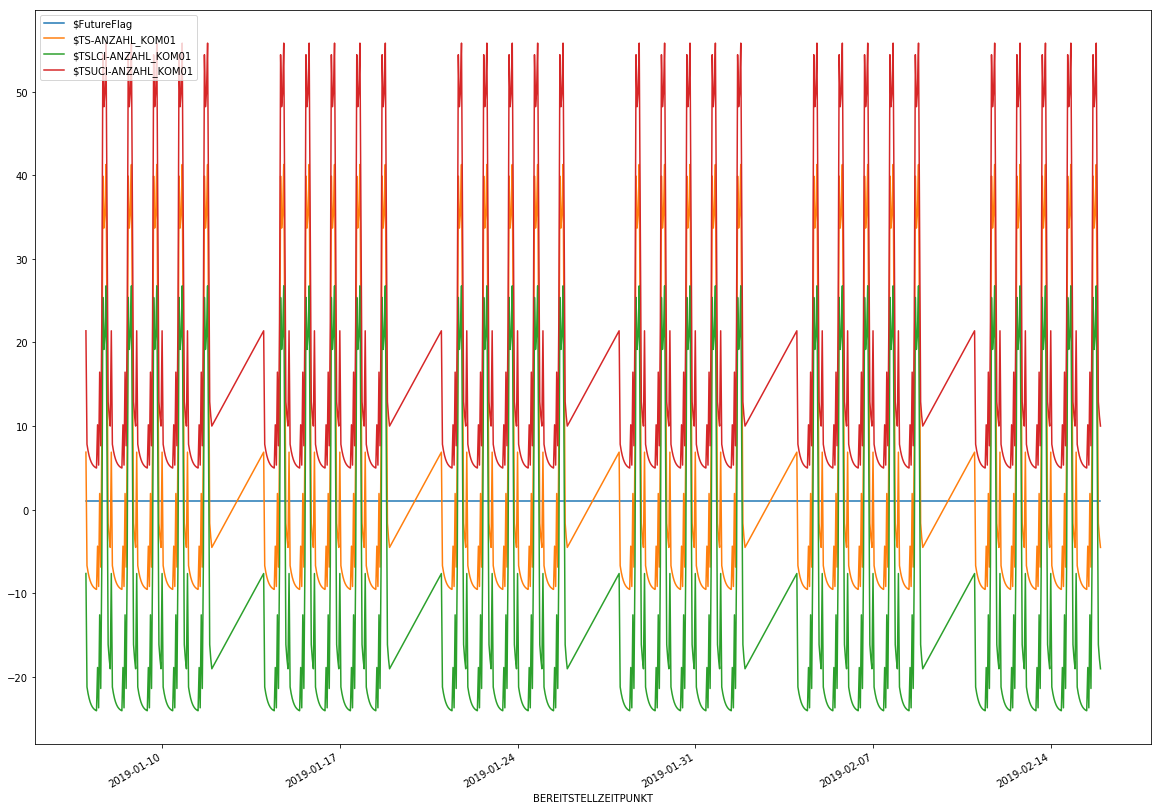

In [14]:
# Plot
dfPredict.set_index(key_ts).plot(figsize=(20,15));

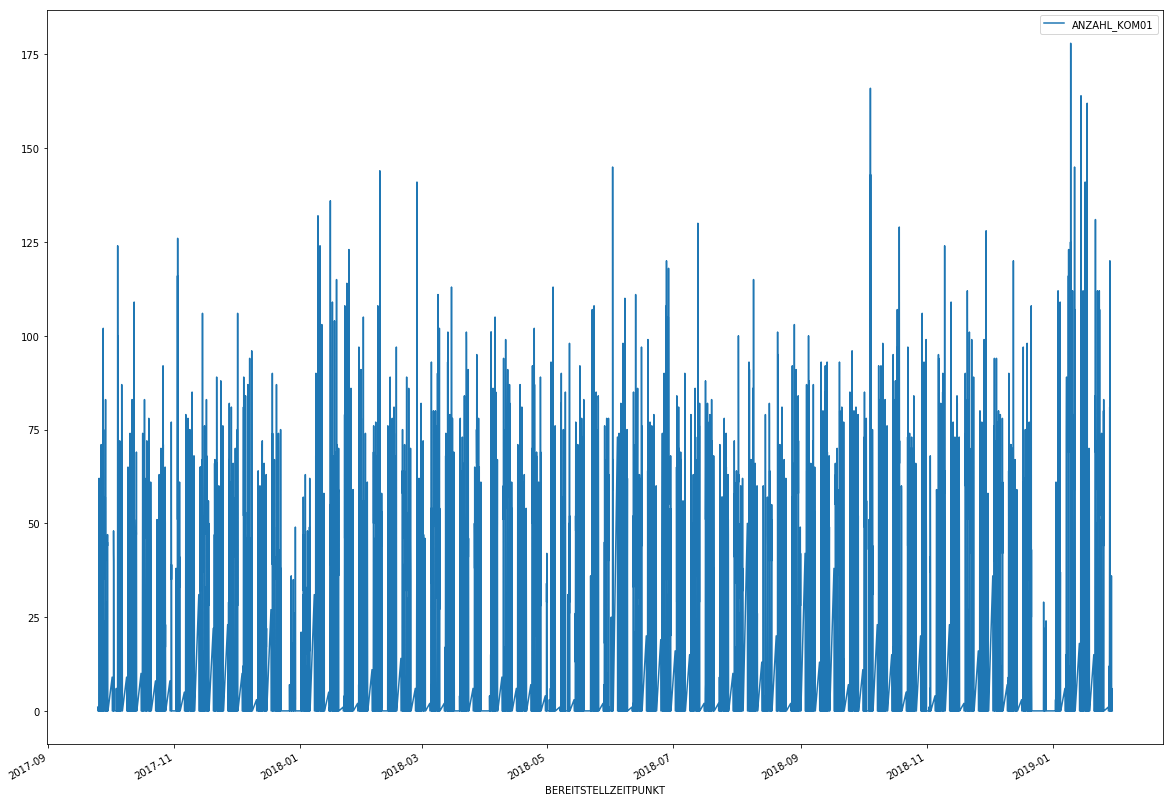

In [19]:
# plot subset of original data
df_ts[[key_ts,'ANZAHL_KOM01']].set_index(key_ts).plot(figsize=(20,15));

In [18]:
# Write out the CSV data to a file object in COS
import io
cos.upload_fileobj(io.BytesIO(dfPredict.to_csv(encoding='utf-8').encode('utf-8')),cos_credentials['BUCKET'],"predicted_{}".format(cos_credentials['FILE']))